# Predicting whether or not a household has Internet Access

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import random
import pickle
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.learning_curve import learning_curve
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from patsy import dmatrices

#### Create Data Frame

In [22]:
files = ['ss13husa.csv', 'ss13husb.csv']

def get_data(files):
    for i, file in enumerate(files):
        if i == 0:
            df = pd.read_csv(file)
        else:
            df = df.append(pd.read_csv(file))
    return df

df = get_data(files)

#### Check that the lengths of the datasets

In [4]:
df.shape

(1476313, 231)

#### See the columns are in the dataset

In [6]:
df.columns

Index([u'RT', u'SERIALNO', u'DIVISION', u'PUMA', u'REGION', u'ST', u'ADJHSG',
       u'ADJINC', u'WGTP', u'NP', 
       ...
       u'wgtp71', u'wgtp72', u'wgtp73', u'wgtp74', u'wgtp75', u'wgtp76',
       u'wgtp77', u'wgtp78', u'wgtp79', u'wgtp80'],
      dtype='object', length=231)

#### Feature Selection

#### Extract features that relate to having internet

In [23]:
def create_internet_column(df):

    # Define Internet Features
    internet_features = ['DSL','DIALUP', 'SATELLITE', 'OTHSVCEX', 'MODEM', 'FIBEROP']
    int_true = {}
    int_false = {}
    # Condition which represents having some form of internet service
    for feature in internet_features:
        int_true[feature] = df[feature] == 1
    
    # Obtain indexes for rows in dataframe that have some form of internet service
    for i, df_temp in enumerate(int_true.values()):
        if i == 0:
            internet_true = df_temp
        else:
            internet_true = internet_true | df_temp    
    
    # Create INTERNET column in dataframe based on indexes of internet_true
    df['INTERNET'] = 1
    df['INTERNET'] = df['INTERNET'].where(internet_true, other = 0)

    return df

In [24]:
df = create_internet_column(df)
df.head()

,RT,SERIALNO,DIVISION,PUMA,REGION,ST,ADJHSG,ADJINC,WGTP,NP,...,wgtp72,wgtp73,wgtp74,wgtp75,wgtp76,wgtp77,wgtp78,wgtp79,wgtp80,INTERNET
0,H,84,6,2600,3,1,1000000,1007549,0,1,...,0,0,0,0,0,0,0,0,0,0
1,H,154,6,2500,3,1,1000000,1007549,51,4,...,53,59,84,49,15,15,20,50,16,1
2,H,156,6,1700,3,1,1000000,1007549,449,1,...,530,601,579,341,378,387,421,621,486,0
3,H,160,6,2200,3,1,1000000,1007549,16,3,...,24,33,7,7,13,18,23,23,5,0
4,H,231,6,2400,3,1,1000000,1007549,52,1,...,18,37,49,103,38,49,51,46,47,0


In [25]:
def drop_irrelevant_features(df):

    features = [#'RT',          # Record Type
     #'SERIALNO',    # Housing Unit Serial No.
     #'DIVISION',    # Division Code
     #'PUMA',        # Public Use Microdata Area Code
     'REGION',      # Region
     'ST',          # State Code
     #'ADJHSG',     # Adjustment factor for Housing
     #'ADJINC',     # Inflation adjustment for Income
     #'WGTP',       # Housing Weight
     'NP',          # Number of person records following this household
     'TYPE',        # Type of Unit 

     #'ACR',         # Lot Size
     #'AGS',        # Sales of Agriculture Products
     'BATH',        # Bathtub or Shower
     'BDSP',        # Number of bedrooms
     'BLD',         # Units in Structure
     'BROADBND',    # Mobile Broadband Plan
     #'BUS',         # Business or medical office on property
     #'COMPOTHX',   # Other computer equipment
     #'CONP',       # Condo Fee

     #'ELEP',       # Electricity Monthly Cost

     'FS',          # Yearly Food Stamp Recipiency
     #'FULP',       # Fuel Cost (other than gas and elec)
     #'GASP',       # Monthly Gas Cost
     'HANDHELD',    # Handheld Computer
     #'HFL',        # House Heating Fuel
     #'INSP',       # Fire/Hazard/Flood Insurance
     'LAPTOP',      # Laptop?
     #'MHP',        # Mobile Home Costs

     #'MRGI',       # First Mortgage includes fire/hazard/flood insurance
     #'MRGP',       # First Mortgage Payment
     #'MRGT',       # First Mortgage Payment includes real estate taxes
     #'MRGX',       # First Mortgage Status

     #'REFR',       # Refridgerator
     'RMSP',        # Number of Rooms
     #'RNTM',        # Meals included in rent
     #'RNTP',        # Monthly Rent
     #'RWAT',       # Hot and Cold Water Running
     #'RWATPR',     # Running Water

     'SINK',        # Sink with a Faucet
     #'SMP',        # Total payment on all second and junior mortgages
     'STOV',        # Stove or Range
     'TEL',         # Telephone
     'TEN',         # Tenure
     #'TOIL',       # Flush Toilet
     #'VACS',        # Vacancy Status
     #'VALP',        # Property Value
     #'VEH',        # Vehicles Available
     #'WATP',       # Water Yearly Cost
     'YBL',         # When Structure first built
     #'FES',         # Family Type and Employment Status
     #'FFINCP',      # Family income allocation flag      
     #'FGRNTP',      # Yearly food stamp allocation flag
     #'FHINCP',      # Household income allocation flag
     #'FINCP',       # Family Income
     #'FPARC',       # Family presence and age of related children
     #'FSMOCP',      # Selected monthly owner cost allocation flag
     #'GRNTP',       # Gross Rent
     #'GRPIP',       # Gross rent as a percentage of household income
     'HHL',         # Household Language
     'HHT',         # Household/family Type
     'HINCP',       # Household income (past 12 months)
     'HUGCL',       # Household w/ grandparent living w/ grandchildren
     'HUPAC',       # Children Present
     #'HUPAOC',     # HH presence and age of own children
     #'HUPARC',     # HH presence and age of related children
     'KIT',         # Complete kitchen facilities
     'LNGI',        # Limited English Speaking Households
     'MULTG',       # Multigenerational Household
     #'MV',          # When moved into this house or apartment
     'NOC',         # Number of children in household
     #'NPF',         # Number of persons in family
     'NPP',         # Grandparent headed household w/ no parent present
     'NR',          # Presence of nonrelative in household
     'NRC',         # Number of related children in household
     #'OCPIP',       # Selected monthly owner costs as a percentage of household income
     'PARTNER',     # Unmarried partner household
     'PLM',         # Complete plumbing facilities
     'PSF',         # Presence of subfamilies in Household
     'R18',         # Presence of persons under 18 years in household
     'R60',         # Presence of persons 60 years and over in household
     'R65',         # Presence of persons 65 years and over in household
     #'RESMODE',    # Response Mode
     #'SMOCP',      # Selected Monthly Owner Costs
     #'SMX',        # Second or junior mortgage home equity loan status
     #'SRNT',       # Specified Rent Unit
     'SSMC',        # Same Sex Marriage Households
     'SVAL',        # Specifice value owner unit
     #'TAXP',        # Property Taxes (yearly)
     #'WIF',         # Workers in family during past 12 months
     #'WKEXREL'     # Work experience of householder or spouse
     #'WORKSTAT'    # Work status of householder or spouse in family households
     #'ACCESS',      # Access to the Internet
     #'DIALUP',      # Dial-up Service
     #'DSL',         # DSL Service
     #'FIBEROP',     # Fiber-optic Internet Service
     #'MODEM',       # Cable Internet Service
     #'OTHSVCEX',   # Other internet services
     #'SATELLITE',   # Satellite Internet Service
     'INTERNET'     # Flag indicator of internet service
    ]
    
    return df[features]

In [26]:
df = drop_irrelevant_features(df)

In [28]:
def drop_missing_data(df):
    return df.dropna()

In [29]:
df = drop_missing_data(df)

In [30]:
def specify_data_types(df):
    df['REGION'] = df['REGION'].astype(object)      # Region, obj
    df['ST'] = df['ST'].astype(object)          # State Code, obj
    df['NP'] = df['NP'].astype(int)          # Number of person records following this household, int
    df['TYPE'] = df['TYPE'].astype(object)        # Type of Unit, obj 
    df['BATH'] = df['BATH'].astype(object)        # Bathtub or Shower, obj
    df['BDSP'] = df['BDSP'].astype(int)        # Number of bedrooms, int
    df['BLD'] = df['BLD'].astype(object)         # Units in Structure, obj
    df['BROADBND'] = df['BROADBND'].astype(object)    # Mobile Broadband Plan, obj
    df['FS'] = df['FS'].astype(object)          # Yearly Food Stamp Recipiency, obj
    df['HANDHELD'] = df['HANDHELD'].astype(object)    # Handheld Computer, obj
    df['LAPTOP'] = df['LAPTOP'].astype(object)      # Laptop?, obj
    df['RMSP'] = df['RMSP'].astype(int)        # Number of Rooms, int
    df['SINK'] = df['SINK'].astype(object)        # Sink with a Faucet, obj
    df['STOV'] = df['STOV'].astype(object)        # Stove or Range, obj
    df['TEL'] = df['TEL'].astype(object)         # Telephone, obj
    df['TEN'] = df['TEN'].astype(object)         # Tenure, obj
    df['YBL'] = df['YBL'].astype(object)         # When Structure first built, obj
    df['HHL'] = df['HHL'].astype(object)         # Household Language, obj
    df['HHT'] = df['HHT'].astype(object)         # Household/family Type, obj
    df['HINCP'] = df['HINCP'].astype(float)       # Household income (past 12 months), float
    df['HUGCL'] = df['HUGCL'].astype(object)       # Household w/ grandparent living w/ grandchildren, obj
    df['HUPAC'] = df['HUPAC'].astype(object)       # Children Present, obj
    df['KIT'] = df['KIT'].astype(object)         # Complete kitchen facilities, obj
    df['LNGI'] = df['LNGI'].astype(object)        # Limited English Speaking Households, obj
    df['MULTG'] = df['MULTG'].astype(object)       # Multigenerational Household, obj
    df['NOC'] = df['NOC'].astype(int)         # Number of children in household, int
    df['NPP'] = df['NPP'].astype(object)         # Grandparent headed household w/ no parent present, obj
    df['NR'] = df['NR'].astype(object)          # Presence of nonrelative in household, obj
    df['NRC'] = df['NRC'].astype(int)         # Number of related children in household, int
    df['PARTNER'] = df['PARTNER'].astype(object)     # Unmarried partner household, obj
    df['PLM'] = df['PLM'].astype(object)         # Complete plumbing facilities, obj
    df['PSF'] = df['PSF'].astype(object)         # Presence of subfamilies in Household, obj
    df['R18'] = df['R18'].astype(object)         # Presence of persons under 18 years in household, obj
    df['R60'] = df['R60'].astype(object)         # Presence of persons 60 years and over in household, obj
    df['R65'] = df['R65'].astype(object)         # Presence of persons 65 years and over in household, obj
    df['SSMC'] = df['SSMC'].astype(object)        # Same Sex Marriage Households, obj
    df['SVAL'] = df['SVAL'].astype(object)        # Specifice value owner unit, obj
    df['INTERNET'] = df['INTERNET'].astype(int)      # Flag indicator of internet service, obj
    return df

In [31]:
df = specify_data_types(df)

#### 910,225 rows remain for people who have specified yes or no to internet.

In [36]:
df.shape

(910225, 38)

#### These columns were removed because a large amount of the data were NA's
[ACR, BUS, INSP, MRGX, VALP, FES, FINCP, FPARC, FSMOCP, MV, NPF, OCPIP, SMOCP, TAXP, WIF, WKEXREL, WORKSTAT]

### Categorical Variables

#### Create Dummy Variables

In [2]:
df = pickle.load(open('households.p', 'rb'))

In [3]:
rows = random.sample(df.index, 20000)
df_sample = df.ix[rows]
df_test = df.drop(rows)


In [4]:
from patsy import dmatrices
y, X = dmatrices('''INTERNET ~ 
                 C(REGION) + 
                 C(ST) + 
                 NP + 
                 C(TYPE) + 
                 C(BATH) +
                 BDSP +
                 C(BLD) + 
                 C(BROADBND) +
                 C(FS) +
                 C(HANDHELD) +
                 C(LAPTOP) +
                 RMSP +
                 C(SINK) +
                 C(STOV) +
                 C(TEL) +
                 C(TEN) +
                 C(YBL) +
                 C(HHL) +
                 C(HHT) +
                 HINCP +
                 C(HUGCL) +
                 C(HUPAC) +
                 C(KIT) +
                 C(LNGI) +
                 C(MULTG) +
                 NOC +
                 C(NPP) +
                 C(NR) +
                 NRC +
                 C(PARTNER) +
                 C(PLM) +
                 C(PSF) +
                 C(R18) +
                 C(R60) +
                 C(R65) +
                 C(SSMC) +
                 C(SVAL) 
                 ''', df_sample, return_type = 'dataframe')



In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=4444)

In [7]:
y_train = y_train.ix[:,'INTERNET'].ravel()
X_train = scale(X_train)
X_test = scale(X_test)

In [8]:
def test_random_forest_n_estimators_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(n_estimators = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')

In [9]:
def test_random_forest_max_depth_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(max_depth = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')

In [10]:
def test_random_forest_min_samples_split_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = RandomForestClassifier(min_samples_split=param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('min_samples_split')
    plt.ylabel('Accuracy')

In [11]:
def test_Gaussian_NB_estimators():
    model = GaussianNB()
    fitted = model.fit(X_train, y_train)
    #Training Accuracy
    y = (accuracy_score(y_train, fitted.predict(X_train)))
    #Test Accuracy
    z = (accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(range(1,20), [y] * 19)
    ts, = plt.plot(range(1,20), [z] * 19)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('Gaussian_NB')
    plt.ylabel('Accuracy')

In [12]:
def test_KNN_test_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = KNeighborsClassifier(n_neighbors = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('# Neighbors')
    plt.ylabel('Accuracy')

In [30]:
def test_SVM_test_C_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = SVC(C = param, kernel = 'linear')
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('C')
    plt.ylabel('Accuracy')

In [31]:
def test_SVM_rbf_test_C_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = SVC(C = param, kernel = 'rbf')
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('C')
    plt.ylabel('Accuracy')

In [17]:
def test_decision_tree_min_samples_split_parameter(params):
    x = []
    y = []
    z = []
    for param in params:
        x.append(param)
        model = DecisionTreeClassifier(min_samples_split = param)
        fitted = model.fit(X_train, y_train)
        #Training Accuracy
        y.append(accuracy_score(y_train, fitted.predict(X_train)))
        #Test Accuracy
        z.append(accuracy_score(y_test, fitted.predict(X_test)))
    tr, = plt.plot(x, y)
    ts, = plt.plot(x, z)
    plt.legend((tr, ts), ('Training Accuracy', 'Test Accuracy'), loc = 'best')
    plt.xlabel('Min Samples Split')
    plt.ylabel('Accuracy')

#### Choose 5 estimators

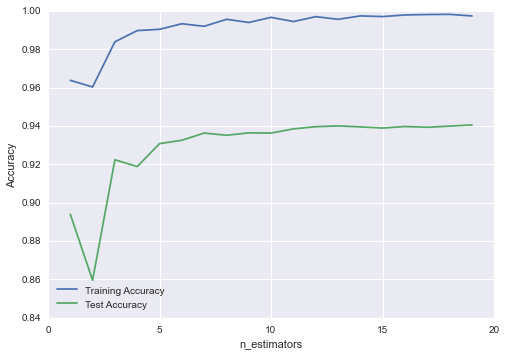

In [24]:
test_random_forest_n_estimators_parameter(range(1,20))

#### Choose max_depth of 16

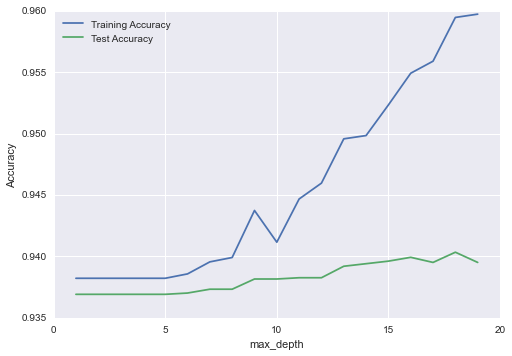

In [25]:
test_random_forest_max_depth_parameter(range(1,20))

#### Choose 4 min samples split

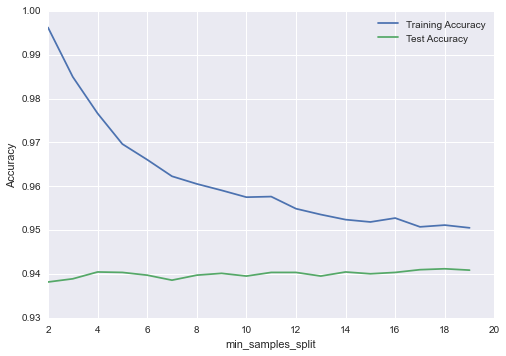

In [26]:
test_random_forest_min_samples_split_parameter(range(2, 20))

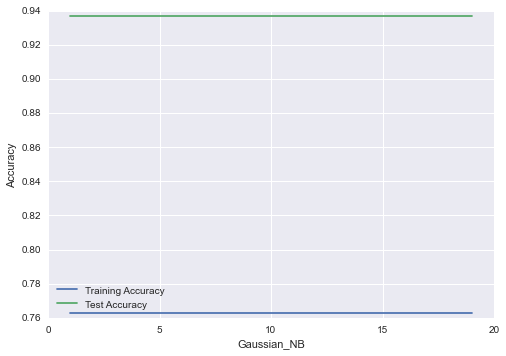

In [27]:
test_Gaussian_NB_estimators()

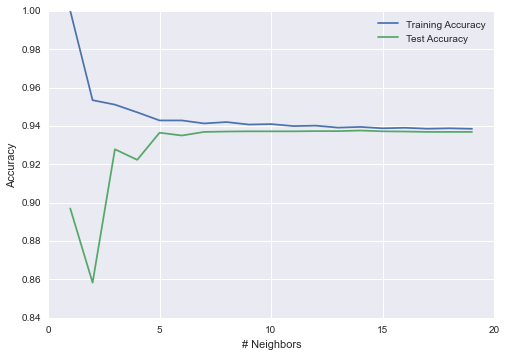

In [28]:
test_KNN_test_parameter(range(1, 20))

In [ ]:
test_SVM_test_C_parameter([.1, 1, 10])

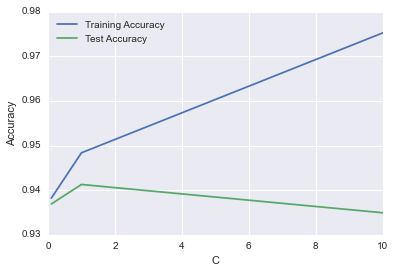

In [ ]:
test_SVM_rbf_test_C_parameter([.1, 1, 10])

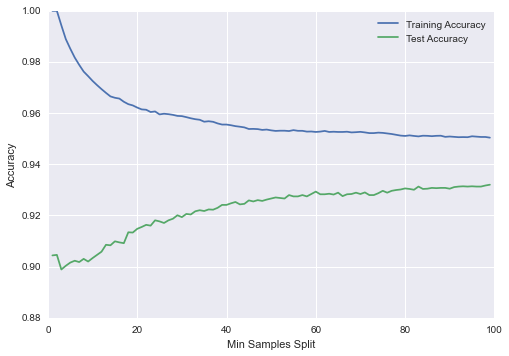

In [21]:
test_decision_tree_min_samples_split_parameter(range(1,100))

In [ ]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall', 'accuracy', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=5, scoring=score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_estimator_)
    print()
    print("Grid scores on development set:")
    print()
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() / 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


In [ ]:
print 'Accuracy: %s' % cross_val_score(KNeighborsClassifier(n_neighbors = 6), X_train, y_train, scoring = 'accuracy', cv = 10).mean()
print 'Precision: %s' % cross_val_score(KNeighborsClassifier(n_neighbors = 6), X_train, y_train, scoring = 'precision', cv = 10).mean()
print 'Recall: %s' % cross_val_score(KNeighborsClassifier(n_neighbors = 6), X_train, y_train, scoring = 'recall_weighted', cv = 10).mean()
print 'F1: %s' % cross_val_score(KNeighborsClassifier(n_neighbors = 6), X_train, y_train, scoring = 'f1', cv = 10).mean()